In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

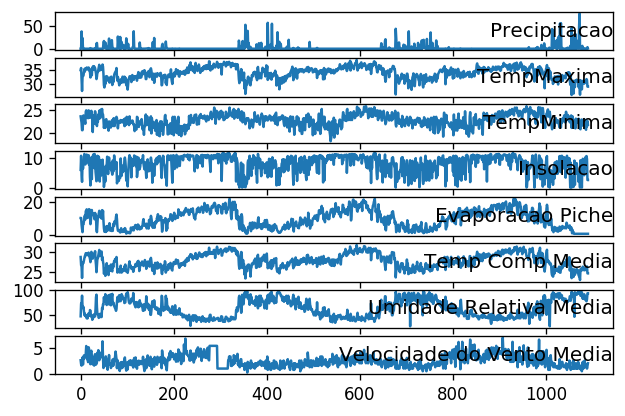

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return model

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    inv_y_hat = scaler.inverse_transform(y_hat)
    inv_y_test = scaler.inverse_transform(y_test)
    
#     new_x_test = x_test[:,-1,:]
#     new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    
#     # invert scaling for forecast
#     inv_y_hat = np.concatenate((y_hat, new_x_test[:, 1:]), axis=1)
#     inv_y_hat = scaler.inverse_transform(inv_y_hat)
#     inv_y_hat = inv_y_hat[:,0]
    
#     # invert scaling for actual value
#     new_test_y = y_test.reshape((len(y_test), 2))
#     inv_y_test = np.concatenate((new_test_y, new_x_test[:, 1:]), axis=1)
#     inv_y_test = scaler.inverse_transform(y_test)
#     inv_y_test = inv_y_test[:,0]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# calculate metrics
def metrics(model, x_test, y_test, scaler):
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    rmse = sqrt(mean_squared_error(y_test, inv_y_hat))
    variance = explained_variance_score(y_test, inv_y_hat)
    maxError = np.max(np.abs(y_test - inv_y_hat))
    meanAbsolutError = mean_absolute_error(y_test, inv_y_hat)
    medianAbsoluteError = np.median(np.abs(y_test - inv_y_hat))
    
    return [rmse, variance, maxError, meanAbsolutError, medianAbsoluteError]

In [11]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    metrics_list = []
    rmse = []
    variance = []
    maxError = []
    meanAbsolutError = []
    medianAbsoluteError = []
    i = len(days_to_predict) - 1
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        model = myLSTM(x_train, y_train, x_test, y_test, scaler)    
        metrics_list += metrics(model, x_test, y_test, scaler)
        
        rmse += [metrics_list[0]]
        variance += [metrics_list[1]]
        maxError += [metrics_list[2]]
        meanAbsolutError += [metrics_list[3]]
        medianAbsoluteError += [metrics_list[4]]
        
        i -= 1
        dataset = dataset[:-1]
        
    print('Test RMSE -------------------------- {:.4}'.format(np.mean(rmse)))
    print('Test VARIANCE ---------------------- {:.4}'.format(np.mean(variance)))
    print('Test MAX-ERROR --------------------- {:.4}'.format(np.mean(maxError)))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(np.mean(meanAbsolutError)))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(np.mean(medianAbsoluteError)))

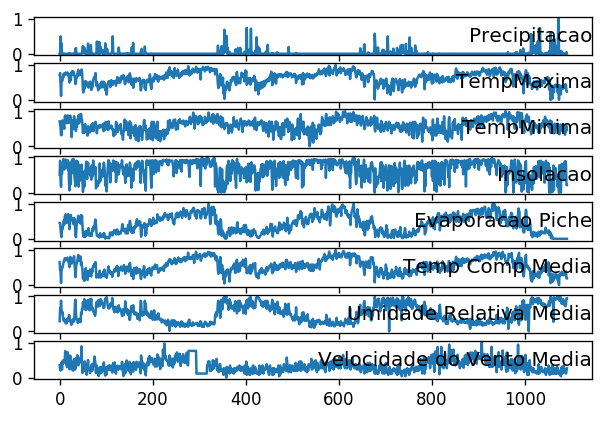

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 0.2817 - mean_squared_error: 0.1194 - val_loss: 0.2339 - val_mean_squared_error: 0.0865
Epoch 2/1000
 - 0s - loss: 0.1499 - mean_squared_error: 0.0359 - val_loss: 0.1537 - val_mean_squared_error: 0.0328
Epoch 3/1000
 - 0s - loss: 0.1410 - mean_squared_error: 0.0312 - val_loss: 0.1531 - val_mean_squared_error: 0.0438
Epoch 4/1000
 - 0s - loss: 0.1355 - mean_squared_error: 0.0289 - val_loss: 0.1583 - val_mean_squared_error: 0.0389
Epoch 5/1000
 - 0s - loss: 0.1320 - mean_squared_error: 0.0271 - val_loss: 0.1518 - val_mean_squared_error: 0.0440
Epoch 6/1000
 - 0s - loss: 0.1215 - mean_squared_error: 0.0233 - val_loss: 0.1599 - val_mean_squared_error: 0.0490
Epoch 7/1000
 - 0s - loss: 0.1157 - mean_squared_error: 0.0215 - val_loss: 0.1681 - val_mean_squared_error: 0.0538
Epoch 8/1000
 - 0s - loss: 0.1114 - mean_squared_error: 0.0204 - val_loss: 0.1562 - val_mean_squared_error: 0.0454
Epoch 9/1000
 - 0s - loss: 0.1101 -

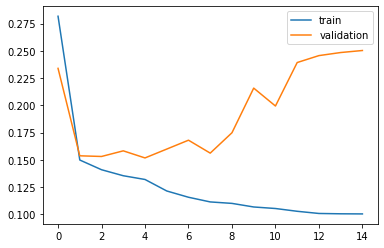

ValueError: operands could not be broadcast together with shapes (1,2) (8,) (1,2) 

In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict, min_max_scaler)